In [1115]:
#general
import os
import random
from datetime import datetime

# data structures
import pandas as pd 
import numpy as np

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# data prep
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split

# model and metrics
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Import data

In [1116]:
data_dir = 'data' #name of folder w/ csv files

def load_all(dir):
    dataframes = []
    for filename in os.listdir(dir):
        f = os.path.join(dir, filename)
        # checking if it is a file
        if os.path.isfile(f):
            try: 
                df = (pd.read_csv(f))
                dataframes.append(df)
            except: print(f'couldn\'t read file {f}')
    return pd.concat(dataframes, ignore_index=True)

df = load_all(data_dir)
print(f'number of records: {len(df)}')

#print(df.head())

number of records: 42488


## Oczyszczenie danych

### Interpret data types correctly

In [1117]:
#check types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42488 entries, 0 to 42487
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  42488 non-null  object 
 1   stars                 42488 non-null  int64  
 2   price                 42488 non-null  int64  
 3   price_per_person      42488 non-null  float64
 4   rating                42156 non-null  float64
 5   opinions              42230 non-null  float64
 6   distance_from_centre  42488 non-null  float64
 7   free_cancellation     42488 non-null  bool   
 8   breakfast             42488 non-null  bool   
 9   city                  42488 non-null  object 
 10  date                  42488 non-null  object 
 11  adults                42488 non-null  int64  
 12  children              42488 non-null  int64  
dtypes: bool(2), float64(4), int64(4), object(3)
memory usage: 3.6+ MB


In [1118]:
# interpret dates properly
df['date'] = df['date'].apply(lambda x: datetime.strptime(x.split()[0], '%Y-%m-%d'))

### Missing data

In [1119]:
#df.isnull().sum()

def show_missing_values():
    nulls = df.isnull()
    null_values = nulls.sum().sort_values(ascending=False)
    percentage = nulls.sum() / nulls.count()*100
    missing_values = pd.concat([null_values, percentage], axis=1, keys=['Number', 'Percentage'], sort=False)
    return missing_values[missing_values['Percentage'] != 0]

show_missing_values()

,Number,Percentage
rating,332,0.781397
opinions,258,0.607230


Danych brakuje jedynie w dwóch kolumnach i w dość małym procencie rekordów. Nie powinno to mieć wpływu na wyniki

#### reviews

booking nie wyświetla liczby opinii kiedy jest to 0, co odpowiada prawdopodobnie za większość brakujących wartości

In [1120]:
#print(df[df['opinions'].isna()])
df['opinions'] = df['opinions'].fillna(0)

#### rating

In [1121]:
# mean with standard deviation

mean = df['rating'].mean()
std = df['rating'].std()

df['rating'] = df['rating'].fillna(random.uniform(mean - std, mean + std))

### Dropping irrelevant values

Ponieważ dane zebrałam w tym przypadku tylko dla jednego miasta oraz nie uwzględniam udziału dzieci, odpowiednie kolumny zostały usunięte. 

Nazwa hotelu nie będzie miała wpływu na jego cenę

Darmowe odwołanie zamówienia jest zawsze oznaczone jako prawda (prawdopodobnie przez lekko przekłamany sposób wyświetlania bookingu), więc nie będzie miało wpływu na cenę.

W tym raporcie skupiam się na cenie per osoba, więc kolumna z łączną ceną rezerwacji może zostać usunięta.

In [1122]:
free_cancel_num = len(df[df['free_cancellation'] == True])
no_free_cancel_num = len(df[df['free_cancellation'] == False])

print(f'Number of reservations with free_cancellation: {free_cancel_num}')
print(f'Number of reservations with no free_cancellation: {no_free_cancel_num}')

Number of reservations with free_cancellation: 42488
Number of reservations with no free_cancellation: 0


In [1123]:
df = df.drop(columns=['name', 'children', 'city', 'free_cancellation', 'price'])
#print(df)


## Dystrybucja wartości

In [1124]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) #ignore distplot depreciation

#### price per person

average price per person: 181.15868056863113
standard deviation: 400.6744124792251


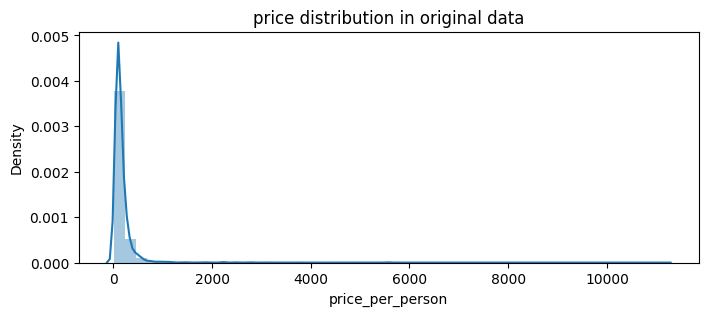

In [1125]:
# calculate price statistics
price_mean = np.mean(df['price_per_person'])
price_std = np.std(df['price_per_person'])

print(f'average price per person: {price_mean}')
print(f'standard deviation: {price_std}')

# make plot
plt.figure(figsize=(8,3))
sns.distplot(df['price_per_person'])
#sns.displot(x='price_per_person', data=df, kde=True)
plt.title('price distribution in original data')
plt.show()

2.34
41492
average price per person: 142.90909886243128
standard deviation: 99.03444737168643


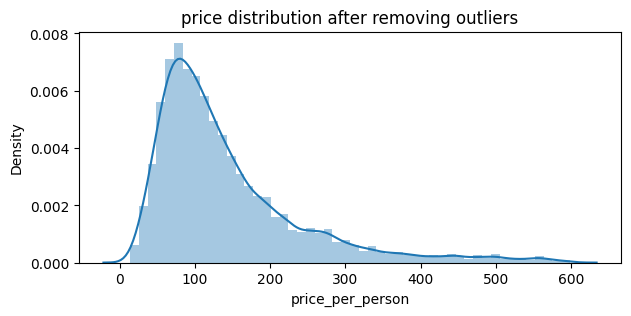

In [1126]:
# remove outliers and count percent of entries removed
old_size = len(df)
df = df[df['price_per_person'] < 600]
percent_removed = round((1 - len(df)/old_size) * 100, 2)
print(percent_removed)
print(len(df))

# calculate price statistics
price_mean = np.mean(df['price_per_person'])
price_std = np.std(df['price_per_person'])

print(f'average price per person: {price_mean}')
print(f'standard deviation: {price_std}')

# make plot
plt.figure(figsize=(7,3))
sns.distplot(df['price_per_person'])
#sns.displot(x='price_per_person', data=df, kde=True)
plt.title('price distribution after removing outliers')
plt.show()



#### date

<Figure size 1000x300 with 0 Axes>

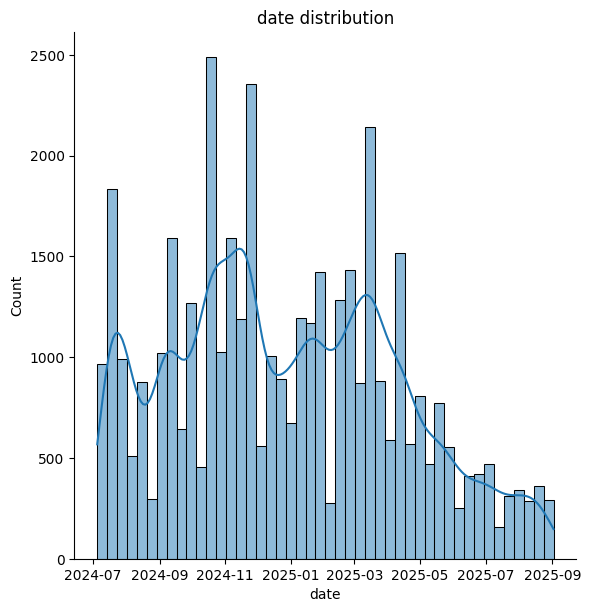

In [1127]:
plt.figure(figsize=(10,3))
#sns.distplot(df['date'])
sns.displot(x='date', data=df, kde=True, height=6)
plt.title('date distribution')
plt.show()

#### number of people

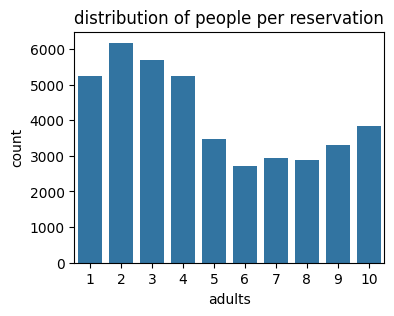

In [1128]:
plt.figure(figsize=(4,3))
sns.countplot(x='adults', data=df)
plt.title('distribution of people per reservation')
plt.show()

#### rating

<Figure size 300x300 with 0 Axes>

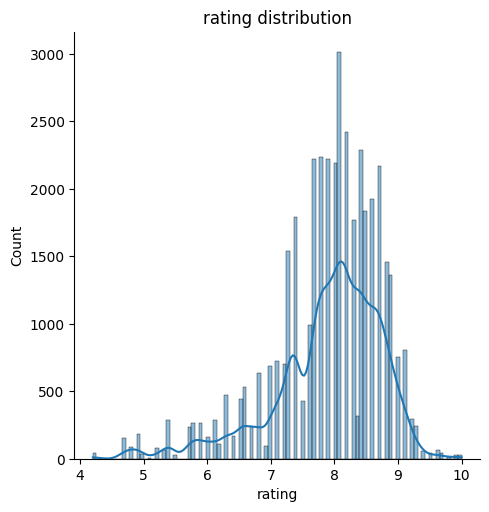

In [1129]:
plt.figure(figsize=(3,3))
#sns.distplot(df['rating'])
sns.displot(x='rating', data=df, kde=True)
plt.title('rating distribution')
plt.show()

#### number of reviews

<Figure size 300x300 with 0 Axes>

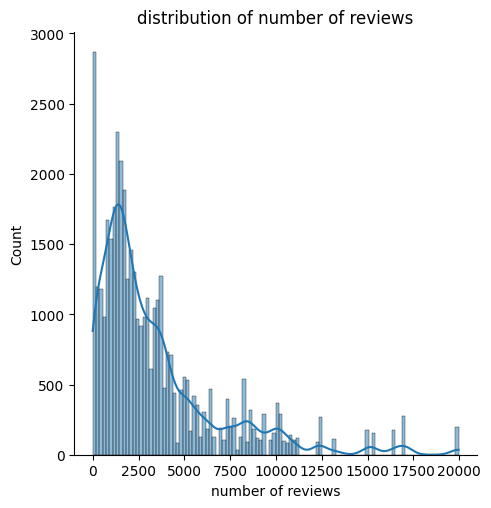

In [1130]:
plt.figure(figsize=(3,3))
#sns.distplot(df['opinions'])
sns.displot(x='opinions', data=df, kde=True)
plt.title('distribution of number of reviews')
plt.xlabel('number of reviews')
plt.show()

#### stars

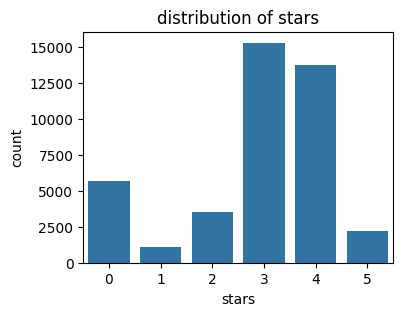

In [1131]:
#df.drop_duplicates('name')

plt.figure(figsize=(4,3))
sns.countplot(x='stars', data=df)
plt.title('distribution of stars')
plt.show()

#### distance from centre

<Figure size 300x300 with 0 Axes>

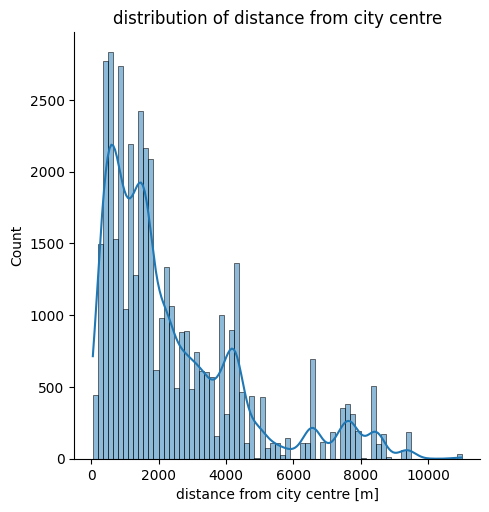

In [1132]:
plt.figure(figsize=(3,3))
#sns.distplot(df['rating'])
sns.displot(x='distance_from_centre', data=df, kde=True)
plt.title('distribution of distance from city centre')
plt.xlabel('distance from city centre [m]')
plt.show()

df = df[df['distance_from_centre'] < 10000]


#### breakfast

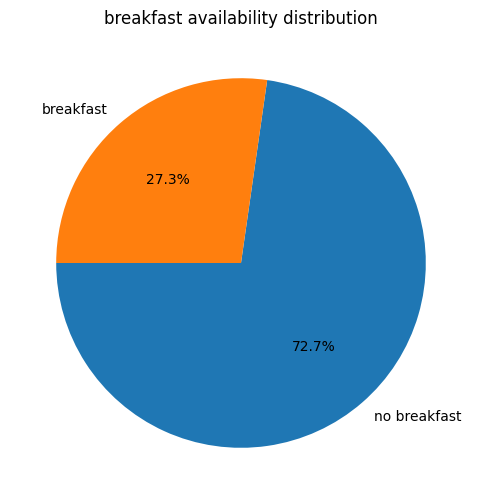

In [1133]:
plt.figure(figsize=(8,6))
breakfast = len(df[df['breakfast'] == 1])
no_breakfast = len(df[df['breakfast'] == 0])
categories=[no_breakfast, breakfast]
labels = ['no breakfast', 'breakfast']
plt.pie(categories, labels=labels, autopct='%1.1f%%', startangle=180)
plt.title('breakfast availability distribution')
plt.show()

## Zależności między danymi

#### price per person to number of people

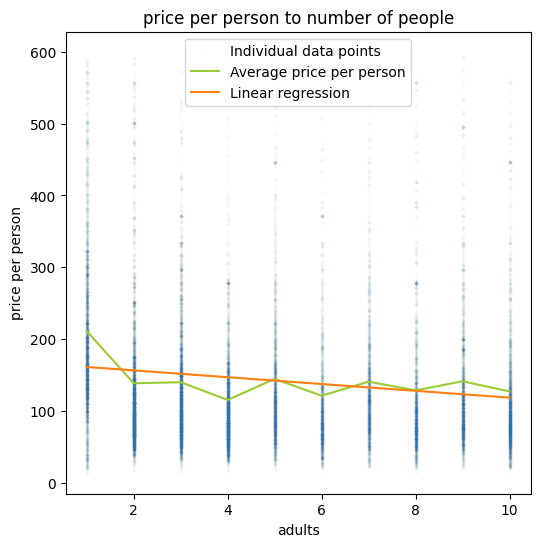

In [1155]:
# Calculate the average price per person for each rating
average_prices = df.groupby('adults')['price_per_person'].mean()

# Create the figure and plot
plt.figure(figsize=(6,6))
plt.scatter(df['adults'], df['price_per_person'], label='Individual data points', color='tab:blue', s=3, alpha=0.007)
plt.plot(average_prices.index, average_prices.values, color='yellowgreen', label='Average price per person')

# linear regression using numpy
coef = np.polyfit(df['adults'], df['price_per_person'], 1)
poly1d_fn = np.poly1d(coef)

x = np.linspace(start=df['adults'].min(), stop=df['adults'].max(), num=300)
plt.plot(x, poly1d_fn(x), color='tab:orange', label='Linear regression')

plt.title('price per person to number of people')
plt.xlabel('adults')
plt.ylabel('price per person')
plt.legend()
plt.show()

#### rating a cena p/o

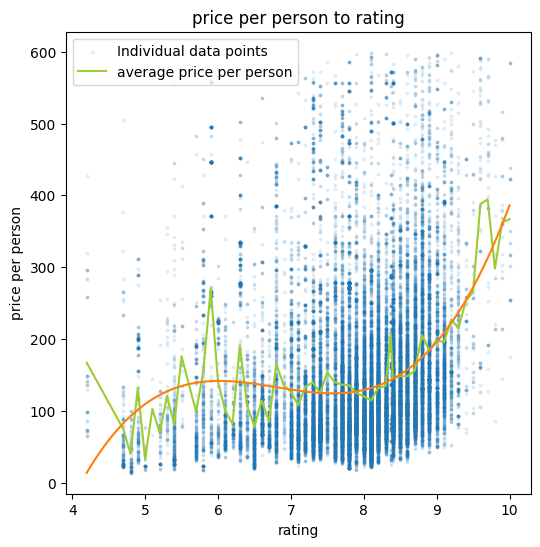

In [1154]:
# Calculate the average price per person for each rating
average_prices = df.groupby('rating')['price_per_person'].mean()

# Create the figure and plot
plt.figure(figsize=(6,6))
plt.scatter(df['rating'], df['price_per_person'], label='Individual data points', color='tab:blue', s=3, alpha=0.1)
plt.plot(average_prices.index, average_prices.values, color='yellowgreen', label='average price per person')

# linear regression using numpy
coef = np.polyfit(df['rating'], df['price_per_person'], 3)
poly1d_fn = np.poly1d(coef)

x = np.linspace(start=df['rating'].min(), stop=df['rating'].max(), num=300)
plt.plot(x, poly1d_fn(x), color='tab:orange')

plt.title('price per person to rating')
plt.xlabel('rating')
plt.ylabel('price per person')
plt.legend()
plt.show()

#### price per person to stars

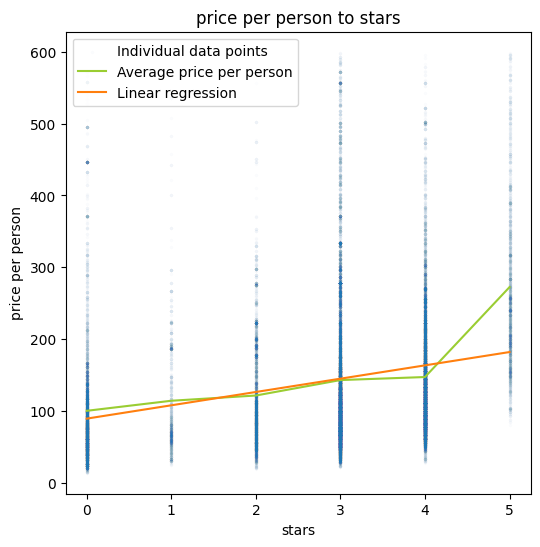

In [1153]:
# Calculate the average price per person per number of stars
average_prices = df.groupby('stars')['price_per_person'].mean()

# Create the figure and plot
plt.figure(figsize=(6,6))
plt.scatter(df['stars'], df['price_per_person'], label='Individual data points', color='tab:blue', s=3, alpha=0.01)
plt.plot(average_prices.index, average_prices.values, color='yellowgreen', label='Average price per person')

# linear regression using numpy
coef = np.polyfit(df['stars'], df['price_per_person'], 1)
poly1d_fn = np.poly1d(coef)

x = np.linspace(start=df['stars'].min(), stop=df['stars'].max(), num=300)
plt.plot(x, poly1d_fn(x), color='tab:orange', label='Linear regression')

plt.title('price per person to stars')
plt.xlabel('stars')
plt.ylabel('price per person')
plt.legend()
plt.show()

<Figure size 600x600 with 0 Axes>

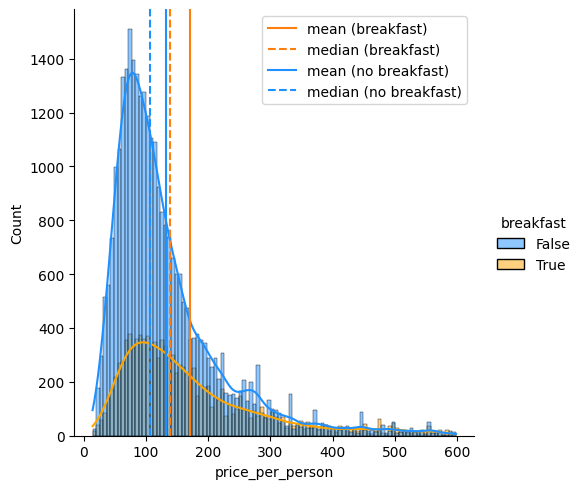

In [1137]:
plt.figure(figsize=(6,6))
sns.displot(x='price_per_person', data=df, hue='breakfast', kde=True, palette = {True: 'orange', False: 'dodgerblue'})

plt.axvline(x=df[df['breakfast'] == True].price_per_person.mean(), c='tab:orange', ls='-', lw=1.5, label='mean (breakfast)')
plt.axvline(x=df[df['breakfast'] == True].price_per_person.median(), c='tab:orange', ls='--', lw=1.5, label='median (breakfast)')

plt.axvline(x=df[df['breakfast'] == False].price_per_person.mean(), c='dodgerblue', ls='-', lw=1.5, label='mean (no breakfast)')
plt.axvline(x=df[df['breakfast'] == False].price_per_person.median(), c='dodgerblue', ls='--', lw=1.5, label='median (no breakfast)')

plt.legend()
plt.show()

#### odległość od centrum a rating

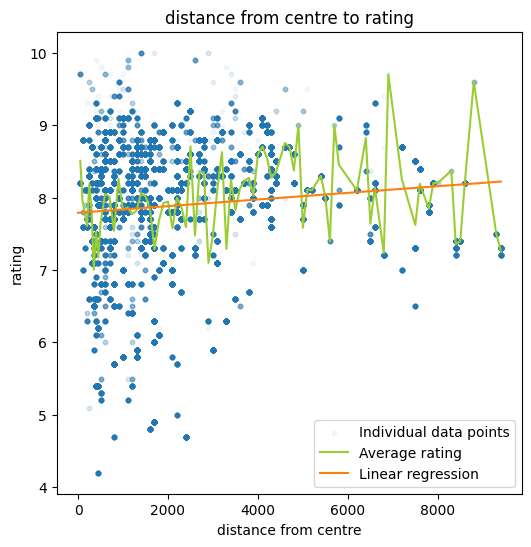

In [1138]:
# Create the figure and plot
plt.figure(figsize=(6,6))
plt.scatter(df['distance_from_centre'], df['rating'], label='Individual data points', color='tab:blue', s=10, alpha=0.05)

# Calculate the average price per person for each rating
average_prices = df.groupby('distance_from_centre')['rating'].mean() 
plt.plot(average_prices.index, average_prices.values, color='yellowgreen', label='Average rating')

# linear regression
coef = np.polyfit(df['distance_from_centre'], df['rating'], 1)
poly1d_fn = np.poly1d(coef)

x = np.linspace(start=0, stop=df['distance_from_centre'].max(), num=300)
plt.plot(x, poly1d_fn(x), color='tab:orange', label='Linear regression')

plt.title('distance from centre to rating')
plt.xlabel('distance from centre')
plt.ylabel('rating')
plt.legend()
plt.show()

#### odległość od centrum a cena p/o

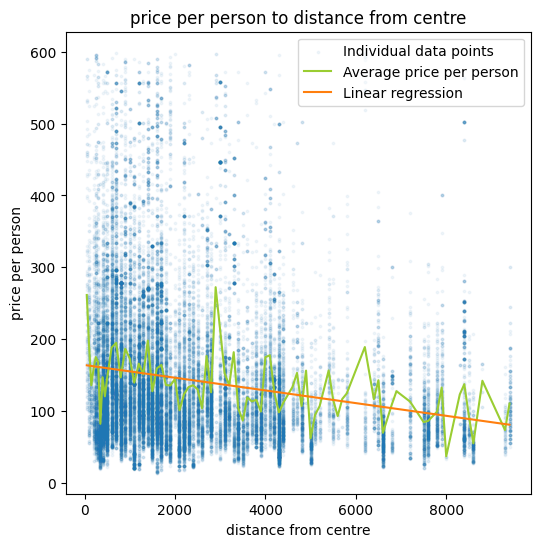

In [1156]:
# Calculate the average price per person for each rating
average_prices = df.groupby('distance_from_centre')['price_per_person'].mean()

# Create the figure and plot
plt.figure(figsize=(6,6))
plt.scatter(df['distance_from_centre'], df['price_per_person'], label='Individual data points', s=3, alpha=0.06)
plt.plot(average_prices.index, average_prices.values, color='yellowgreen', label='Average price per person')

# linear regression using numpy
coef = np.polyfit(df['distance_from_centre'], df['price_per_person'], 1)
poly1d_fn = np.poly1d(coef)

x = np.linspace(start=df['distance_from_centre'].min(), stop=df['distance_from_centre'].max(), num=300)
plt.plot(x, poly1d_fn(x), color='tab:orange', label='Linear regression')

plt.title('price per person to distance from centre')
plt.xlabel('distance from centre')
plt.ylabel('price per person')
plt.legend()
plt.show()

#### data a cena p/o

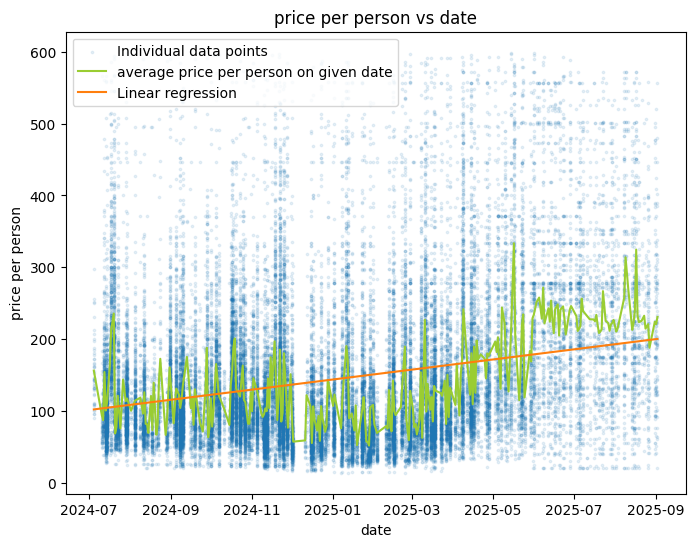

In [1160]:
# Calculate the average price per person for each rating
average_prices = df.groupby('date')['price_per_person'].mean()

# Create the figure and plot
plt.figure(figsize=(8,6))
plt.scatter(df['date'], df['price_per_person'], label='Individual data points', s=3, alpha=0.1)
plt.plot(average_prices.index, average_prices.values, color='yellowgreen', label='average price per person on given date')

# Calculate the difference in days from the reference date
reference_date = pd.to_datetime('2024-07-30')
days_from_reference = (df['date'] - reference_date).dt.days

# linear regression using numpy
coef = np.polyfit(days_from_reference, df['price_per_person'], 1)
poly1d_fn = np.poly1d(coef)

x = np.linspace(days_from_reference.min(), days_from_reference.max(), 300)
plt.plot(reference_date + pd.to_timedelta(x, unit='D'), poly1d_fn(x), color='tab:orange', label='Linear regression')

plt.title('price per person vs date')
plt.xlabel('date')
plt.ylabel('price per person')
plt.legend()
plt.show()

## prepare data

#### split set into attributes and target

In [1141]:
X = df.drop('price_per_person', axis=1)
#X = X.drop(columns=['breakfast'])
y = df['price_per_person']

#### Scale the attributes

convert date to ordinal so it can be scaled properly

In [1142]:
X['date'] = X['date'].map(datetime.toordinal)
#X['date'] = X['date'].map(lambda x: x.month)

In [1143]:
#check types
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41458 entries, 0 to 42487
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   stars                 41458 non-null  int64  
 1   rating                41458 non-null  float64
 2   opinions              41458 non-null  float64
 3   distance_from_centre  41458 non-null  float64
 4   breakfast             41458 non-null  bool   
 5   date                  41458 non-null  int64  
 6   adults                41458 non-null  int64  
dtypes: bool(1), float64(3), int64(3)
memory usage: 2.3 MB


In [1144]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
#print(X)

#### create training and test data set

In [1145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random.randint(0,100), shuffle = True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(37312, 7) (4146, 7) (37312,) (4146,)


## actual regression

In [1146]:
def evaluate(y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R²):", r2)

    return mae, mse, r2

#### Ordinary Least Squares

In [1147]:
# train model
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

print(reg.coef_)

# make predictions on the test data
y_pred = reg.predict(X_test)
ev_lss = evaluate(y_pred)

[ 24.23677957   8.3282219  -17.97375788 -15.09770907  11.8925854
  23.52578677  -6.69883034]
Mean Absolute Error (MAE): 62.91533307571947
Mean Squared Error (MSE): 7778.067068648354
R-squared (R²): 0.23291188297942367


#### Non-Negative Least Squares

In [1148]:
# train model
reg = linear_model.LinearRegression(positive=True)
reg.fit(X_train, y_train)

print(reg.coef_)

# make predictions on the test data
y_pred = reg.predict(X_test)
ev_lss = evaluate(y_pred)

[22.48831734  5.74526954  0.          0.         16.57425227 23.25749664
  0.        ]
Mean Absolute Error (MAE): 66.7213812695659
Mean Squared Error (MSE): 8678.148871964913
R-squared (R²): 0.14414406321433038


#### Ridge

In [1149]:
# train model
reg = linear_model.Ridge(alpha=0.8, max_iter=100, solver='auto')
reg.fit(X_train, y_train)

print(reg.coef_)

# make predictions on the test data
y_pred = reg.predict(X_test)
ev_lss = evaluate(y_pred)

[ 24.23622555   8.32823863 -17.97345512 -15.09744049  11.89234461
  23.52530276  -6.69881979]
Mean Absolute Error (MAE): 62.91527809385261
Mean Squared Error (MSE): 7778.067730783138
R-squared (R²): 0.23291181767840208


#### Lasso

In [1150]:
# train model
reg = linear_model.Lasso(alpha=0.5)
reg.fit(X_train, y_train)

print(reg.coef_)

# make predictions on the test data
y_pred = reg.predict(X_test)
ev_lss = evaluate(y_pred)

[ 23.83548849   7.95750974 -17.60463362 -14.64086747  11.67020706
  23.03331399  -6.33771002]
Mean Absolute Error (MAE): 62.872260344678104
Mean Squared Error (MSE): 7783.133135133431
R-squared (R²): 0.23241225763980644
